In [91]:
import os
import pandas as pd
import numpy as np

import cudf
import nvtabular as nvt

In [92]:
DATA_FOLDER = "./yoochoose-data"
FILENAME_PATTERN = 'yoochoose-clicks.dat'
DATA_PATH = os.path.join(DATA_FOLDER, FILENAME_PATTERN)

!ls $DATA_PATH

./yoochoose-data/yoochoose-clicks.dat


In [94]:

#Accepted data formats are: csv | tsv | parquet
DATA_FORMAT = 'csv' 
#List of columns names to be used for CSV / TSV files without the header line
HEADLESS_CSV_COLUMN_NAMES = ['session_id','timestamp', 'item_id', 'category']

In [95]:
DATA_FORMAT = 'csv' 
if DATA_FORMAT == 'parquet':
    gdf = cudf.read_parquet(DATA_PATH)
    
elif DATA_FORMAT in ['csv', 'tsv']:
    gdf = cudf.read_csv(DATA_PATH,                              
                             sep='\t' if DATA_FORMAT == 'tsv' else ',',
                             names=HEADLESS_CSV_COLUMN_NAMES
                            )

In [96]:
gdf.head()

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0


In [20]:
gdf.dtypes

session_id     int64
timestamp     object
item_id        int64
category      object
dtype: object

In [90]:
gdf.head()

,session_id,timestamp,item_id,category
0,1,2014-04-07 10:51:09.277,214536502,0
1,1,2014-04-07 10:54:09.868,214536500,0
2,1,2014-04-07 10:54:46.998,214536506,0
3,1,2014-04-07 10:57:00.306,214577561,0
4,2,2014-04-07 13:56:37.614,214662742,0


In [97]:
# create time features
sessionTime = (
    ['timestamp'] >> 
    nvt.ops.LambdaOp(lambda col: col.astype('datetime64[ms]')) 
)
sessionTime_day = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.day) >> 
    nvt.ops.Rename(postfix="_day")
)
sessionTime_month = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.month) >> 
    nvt.ops.Rename(postfix="_month")
)
sessionTime_year = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.year) >> 
    nvt.ops.Rename(postfix="_year")
)

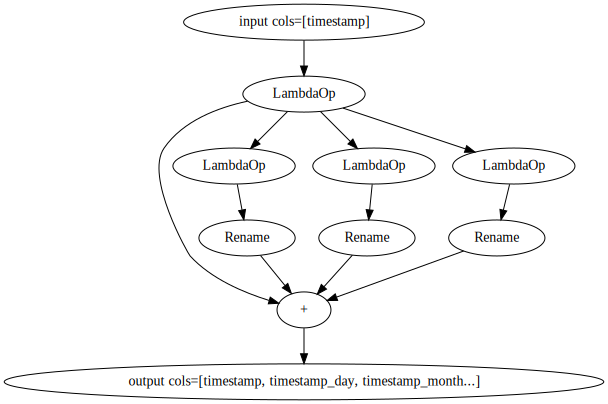

In [98]:
 time_features = (
    sessionTime + 
    sessionTime_day + 
    sessionTime_month + 
    sessionTime_year
)
time_features.graph

In [99]:
time_features.columns

['timestamp', 'timestamp_day', 'timestamp_month', 'timestamp_year']

In [100]:

from nvtabular import ColumnGroup
import nvtabular
dataset = nvt.Dataset(gdf, cpu=False)

keys = ["session_id"]
# Define Groupby Workflow
groupby_features = (['item_id', 'category'] >> nvt.ops.Categorify()) + ['session_id']+time_features >> nvt.ops.Groupby(
    groupby_cols=keys, 
    sort_cols=["timestamp"],
    aggs={
        "item_id": ["list", "first", "last"],
        "category": ["list", "first", "last"],
        "timestamp": ["list", "first", "last"],
        },
    name_sep="-")

In [101]:
groupby_features.columns

['category-last',
 'item_id-list',
 'timestamp-list',
 'item_id-first',
 'category-list',
 'category-first',
 'timestamp-first',
 'item_id-last',
 'timestamp-last',
 'session_id']

In [102]:
workflow = nvt.Workflow(groupby_features + time_features)

In [103]:
workflow.column_group.columns

['category-last',
 'item_id-list',
 'timestamp-list',
 'item_id-first',
 'category-list',
 'category-first',
 'timestamp-first',
 'item_id-last',
 'timestamp-last',
 'session_id',
 'timestamp',
 'timestamp_day',
 'timestamp_month',
 'timestamp_year']

In [104]:
dataset = nvt.Dataset(gdf, cpu=False)
workflow.fit(dataset)
new_gdf = workflow.transform(dataset).to_ddf().compute()

In [116]:
new_gdf.head(10)

,category-last,item_id-list,timestamp-list,item_id-first,category-list,category-first,timestamp-first,item_id-last,timestamp-last,session_id,timestamp,timestamp_day,timestamp_month,timestamp_year
0,1,"[2054, 2053, 2055, 9877]","[2014-04-07T10:51:09.277, 2014-04-07T10:54:09....",2054,"[1, 1, 1, 1]",1,2014-04-07 10:51:09.277,9877,2014-04-07 10:57:00.306,1,2014-04-07 10:51:09.277,7,4,2014
1,1,"[19449, 19449, 40789, 32517, 32523, 4854]","[2014-04-07T13:56:37.614, 2014-04-07T13:57:19....",19449,"[1, 1, 1, 1, 1, 1]",1,2014-04-07 13:56:37.614,4854,2014-04-07 14:02:36.889,2,2014-04-07 10:54:09.868,7,4,2014
2,1,"[28990, 35311, 43179]","[2014-04-02T13:17:46.940, 2014-04-02T13:26:02....",28990,"[1, 1, 1]",1,2014-04-02 13:17:46.940,43179,2014-04-02 13:30:12.318,3,2014-04-07 10:54:46.998,7,4,2014
3,1,"[44326, 26362]","[2014-04-07T12:09:10.948, 2014-04-07T12:26:25....",44326,"[1, 1]",1,2014-04-07 12:09:10.948,26362,2014-04-07 12:26:25.416,4,2014-04-07 10:57:00.306,7,4,2014
4,1,"[25633, 41161]","[2014-04-06T16:58:20.848, 2014-04-06T17:02:26....",25633,"[1, 1]",1,2014-04-06 16:58:20.848,41161,2014-04-06 17:02:26.976,6,2014-04-07 13:56:37.614,7,4,2014
5,1,"[41233, 41185]","[2014-04-02T06:38:53.104, 2014-04-02T06:39:05....",41233,"[1, 1]",1,2014-04-02 06:38:53.104,41185,2014-04-02 06:39:05.854,7,2014-04-07 13:57:19.373,7,4,2014
6,1,"[45038, 45038]","[2014-04-06T08:49:58.728, 2014-04-06T08:52:12....",45038,"[1, 1]",1,2014-04-06 08:49:58.728,45038,2014-04-06 08:52:12.647,8,2014-04-07 13:58:37.446,7,4,2014
7,1,"[9614, 9614, 9614]","[2014-04-06T11:26:24.127, 2014-04-06T11:28:54....",9614,"[1, 1, 1]",1,2014-04-06 11:26:24.127,9614,2014-04-06 11:29:13.479,9,2014-04-07 13:59:50.710,7,4,2014
8,1,"[39928, 39928, 39967, 39967, 39967, 29055, 795...","[2014-04-03T10:44:35.672, 2014-04-03T10:45:01....",39928,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,2014-04-03 10:44:35.672,39476,2014-04-03 10:57:39.433,11,2014-04-07 14:00:38.247,7,4,2014
9,1,"[29311, 29311]","[2014-04-02T10:30:13.176, 2014-04-02T10:33:12....",29311,"[1, 1]",1,2014-04-02 10:30:13.176,29311,2014-04-02 10:33:12.621,12,2014-04-07 14:02:36.889,7,4,2014
